<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/with_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [ ]:
import torch
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image
!pip install graphviz
!pip install torchview
!pip install torchinfo

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    HOME_DIR = "/content"
else:
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"

In [ ]:
!git clone https://github.com/sergsb/IUPAC2Struct.git

fatal: destination path 'IUPAC2Struct' already exists and is not an empty directory.


In [ ]:
sys.path.append(f"{HOME_DIR}/IUPAC2Struct")

In [ ]:
!ls drive/MyDrive | grep iupav

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if IN_COLAB:
    os.system('cp drive/MyDrive/WWVSB/iupac2smiles_model.pt .')
    # os.system('cp "drive/MyDrive/iupac2smiles_model.py" .') wtf stupid

M = torch.load(f"{HOME_DIR}/iupac2smiles_model.pt", map_location=device)
M.device = device

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'transformer.Transformer' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribu

In [ ]:
M.tgt_model.encode("CC(=O)Nc1ccc(O)cc1")

[27, 27, 8, 23, 38, 9, 37, 54, 14, 54, 54, 54, 8, 38, 9, 54, 54, 14]

In [ ]:
smiles_tokenlizer = M.tgt_model.encode

In [ ]:
!pip install torchviz

# Data Processing

In [ ]:

if IN_COLAB:
  if not "80k" in "".join(os.listdir("/content")):
    os.system("cp drive/MyDrive/80k.zip .")
    os.system("cp drive/MyDrive/80k.csv .")
    os.system("unzip 80k.zip")
    HOME_DIR = "/content"
else:
  if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
    os.system("wget file.weasoft.com/80k.zip")
    os.system("wget http://file.weasoft.com/80k.csv")
    os.system("unzip 80k.zip")
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"


In [ ]:
import os
ids = [i.split("_")[0] for i in os.listdir(f"{HOME_DIR}/rendered")]

with open("ids.txt", "w") as f:
    f.write("\n".join(list(set(ids))))

import pandas as pd
csv = pd.read_csv("80k.csv")
cids = csv["cid"]
csv.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [ ]:
Ys = {}
invalid_cids = []
for i in cids.values:
  try:
    tmp = smiles_tokenlizer(csv[csv["cid"] == i]["canonicalsmiles"].values[0])
    if not tmp == None:
      Ys[i] = tmp
    else:
      smiles_tokenlizer.append(i)

  except:
    invalid_cids.append(i)

In [ ]:
if len(invalid_cids) == 0:
  print("OOHH")

OOHH


In [ ]:
example_in = Image.open(f"{HOME_DIR}/rendered/6912034_0.jpg")
example_out = csv[csv["cid"]==6912034]["canonicalsmiles"].values[0]

In [ ]:
example_out

'CC(=O)C'

In [ ]:
M.tgt_model.decode(Ys[6912034])

'CC(=O)C'

# Model


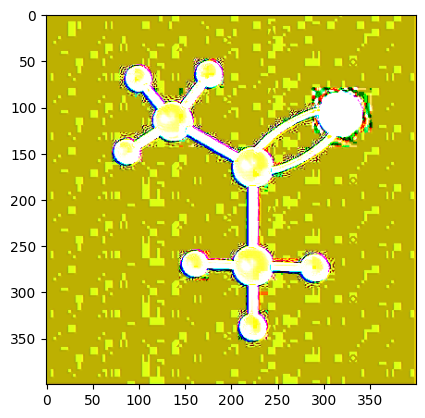

In [ ]:
class ResNetBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, size, downsampling=True):
    super().__init__()
    self.Conv2D = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, (3,3), stride=2 if downsampling else 1, padding=(3 if size%2==0 else 2) if downsampling else 2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, (3,3)),
        torch.nn.BatchNorm2d(out_channels),
    )
    self.project = torch.nn.Conv2d(in_channels, out_channels, (1,1))
    self.pooling = torch.nn.AvgPool2d((2,2)) if downsampling else torch.nn.Identity()
    self.relu = torch.nn.ReLU()
  def forward(self, images):
    x = self.Conv2D(images)
    images = self.pooling(self.project(images))
    return self.relu(x+images)
resblock = ResNetBlock(3,12,400, 0)
inp_img = torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2))
oup = resblock(inp_img)[:,-3:,:,:]
pylab.imshow(torch.permute(oup, (0,2,3,1)).cpu().detach().numpy()[0])

In [ ]:
torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2)).size()

torch.Size([1, 3, 400, 400])

In [ ]:
t = torch.randn(1,64,400,400)
torch.flatten(t)
torch.flatten(t, start_dim=2,end_dim=3).shape

torch.Size([1, 64, 160000])

In [ ]:
class ImageEncoder(torch.nn.Module):
  def __init__(self, channels_list, heads, dropout, orginal_size):
    super().__init__()
    self.conv2d = torch.nn.Sequential(
        # torch.nn.Conv2d(3, 32, (7, 7), stride=3),
        # torch.nn.AvgPool2d((3,3), padding=1)
        torch.nn.Conv2d(3, 32, (7, 7), stride=2, padding=1),
        torch.nn.MaxPool2d((3, 3), stride=2)
    ).to(device)

    self.resnet_blocks = []
    for i in range(len(channels_list)-1):
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i], size=66//(2**i)).to(device))
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i+1], size=66//(2**i), downsampling=0).to(device)) #gangcai self not defined

    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(512,1024),
        torch.nn.GELU(),
        torch.nn.Linear(1024, 512),
        torch.nn.GELU(),
    ).to(device)
    self.posem = torch.nn.Embedding(36, 512).to(device)
    self.mha = torch.nn.MultiheadAttention(channels_list[-1], heads, dropout = 0.1).to(device)

  def forward(self, images):
    features = self.conv2d(images)
    for f in self.resnet_blocks:
      features = f(features)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    ran = torch.arange(0, 36)
    pos = self.posem(ran.to(device).unsqueeze(0))
    features = pos + features#.clone()
    att = self.mha(features, features, features, need_weights=False)[0]
    return self.mlp(att) + features



In [ ]:
# posem = torch.nn.Embedding(36, 512)
# posem(torch.range(0, 36).unsqueeze(1))

In [ ]:
NUM_HEADS = 8
CHANNELS = [32, 64, 128, 256, 512]
DROPOUT = 0.1
inp_img = inp_img.to(device)
encoder = ImageEncoder(CHANNELS, NUM_HEADS, DROPOUT, 400)
encoder(inp_img).shape

torch.Size([1, 36, 512])

In [ ]:
sum(p.numel() for p in encoder.parameters())

2123904

In [ ]:
# from torchinfo import summary
# summary(encoder, (1,3,400,400), depth=10)

In [ ]:
from torchview import draw_graph

In [ ]:
import graphviz
graphviz.set_jupyter_format('png')
encoder.to(device)
model_graph = draw_graph(encoder, input_size=(1, 3, 400, 400), depth=5, device=device)
# model_graph.visual_graph

# Connect with pretrained


In [ ]:
def subsequent_mask(tgt_mask):
    size = tgt_mask.size(-1)
    return tgt_mask.to(torch.uint8) & torch.tril(torch.ones(1,size,size, dtype=torch.uint8)).to(tgt_mask.device)

def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

def find_first_working(x):
  for i in x:
    if i<=71:
      return i


In [ ]:
inp = M.src_model.encode("N-(4-hydroxyphenyl)acetamide")
src = torch.tensor(pad_pack([inp]), device=(M.device))
src_mask = (src != 0).unsqueeze(-2).to(M.device)#.shape
latent = M.T.encoder(M.T.src_embedder(src), (src != 0).unsqueeze(-2).to(M.device))
l = latent.to(torch.device("cpu"))
l.cpu().detach().numpy()[0].shape

<ipython-input-418-f5acc8b72dd7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(pad_pack([inp]), device=(M.device))


(10, 512)

In [ ]:
padded_tgt = pad_pack([[2]]).to(M.device)
empty_start = M.T.tgt_embedder(padded_tgt)

In [ ]:
inp_img = inp_img.cuda()

In [ ]:
inp_img.is_cuda

True

In [ ]:
encoder = encoder.cuda()

In [ ]:
encoder = encoder.to(torch.device('cuda'))

In [ ]:
next(M.T.decoder.parameters()).is_cuda

True

In [ ]:
latent = encoder(inp_img)
src_mask = (torch.zeros(len(latent[0]))).unsqueeze(-2).to(M.device)#.shape
out = M.T.decoder(empty_start, latent, src_mask, subsequent_mask((padded_tgt != 0).unsqueeze(-2)))

In [ ]:
# Test for teaching forcing
# forcing = pad_pack([[2]+M.tgt_model.encode("CC(=O)Nc1ccc(O)cc")]).to(M.device)
forcing = pad_pack([[2,0]]).to(device)
forcing_start = M.T.tgt_embedder(forcing).to(device)

latent = encoder(inp_img)
src_mask = torch.zeros(36).unsqueeze(-2).to(device)
out = M.T.decoder(forcing_start, latent, src_mask, subsequent_mask((forcing != 0).unsqueeze(-2)))
# out = M.T.decoder(forcing_start, l, src_mask, subsequent_mask((forcing != 0).unsqueeze(-2)))
out = M.T.generator(out)
print (out.shape)
ans = []
for i in range(2):
  ans.append(torch.sort(out[0], dim=1,
                        descending=True)[1].cpu().detach().numpy()[i][0])
M.tgt_model.decode(ans)

torch.Size([1, 2, 72])


'=='

In [464]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for i in M.T.decoder.parameters():
  print(i.requires_grad)
  # i.requires_grad == False # FUCK
  i.requires_grad = False

for i in M.T.generator.parameters():
  i.requires_grad = False

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [457]:
sum(p.numel() for p in M.T.decoder.parameters() if p.requires_grad)

25225216

In [ ]:
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    paded = pad_pack(text_in).to(device)
    embedded = self.embeding(paded)
    out = self.decoder(embedded, image_feature,
                       torch.zeros(36).unsqueeze(-2).to(M.device),
                       subsequent_mask((paded != 0)
                       .unsqueeze(-2)))
    out = self.generator(out)
    return out

In [ ]:
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator, max_len):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator
    self.max_len = max_len

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    for i in range(self.max_len):
      paded = pad_pack(text_in).to(device)
      embedded = self.embeding(paded)
      out = self.decoder(embedded, image_feature,
                        torch.zeros(36).unsqueeze(-2).to(M.device),
                        subsequent_mask((paded != 0)
                        .unsqueeze(-2)))
      out = self.generator(out)
      next = torch.sort(out, descending=True)[1][0,0].cpu().detach().numpy()[0] #forgot descending
      if next == 3:
        break
      text_in[0] += [next]
      # print(text_in)
    return M.tgt_model.decode(text_in[0])


In [ ]:
model = Image2SMILES(encoder.to(device),
    M.T.tgt_embedder.to(device),
             M.T.decoder.to(device), M.T.generator.to(device))

In [ ]:
gen = SMILESGenerator(encoder,
    M.T.tgt_embedder,
             M.T.decoder, M.T.generator, 10)

In [ ]:
torch.argmax(model(inp_img, [[2, 0]])[0,0])

tensor(23, device='cuda:0')

In [ ]:
gen(inp_img, [[2]])

'IPIOI//IP('

In [ ]:
def softmax(x):
  t = np.exp(x)
  return t/np.sum(t)

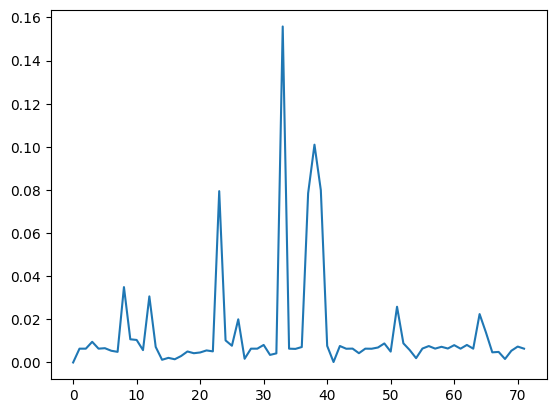

In [ ]:
pylab.plot(softmax(model(inp_img, [[2, 0]])[0][0].cpu().detach().numpy()))

In [ ]:
M.tgt_model.decode([37])

'N'

# Training


In [ ]:
BATCH_SIZE = 64
files = os.listdir("rendered")


def getitiem(index):
  start_index = index * BATCH_SIZE
  Xs_img = []
  Xs_text = []
  y = [] #This is slow, rewrite later
  for _ in range(BATCH_SIZE):
    index = start_index + _
    try:
      id = int(files[index].split("_")[0])
    except:
      break
    index = start_index + _
    img = np.array(Image.open(f"rendered/{files[index]}").rotate(np.random.uniform(0,360), expand = 1).resize((400,400)), dtype="float32")
    noise = np.random.uniform(size=img.shape)*20
    img += noise
    Xs_img.append(img)
    Xs_text.append([2] + Ys[id])
    y.append(Ys[id] + [3])
  Xs_img = torch.permute(torch.tensor(np.array(Xs_img)), (0,3,1,2)).to(device)
  return [Xs_img, pad_pack(Xs_text)], pad_pack(y).to(device)

In [ ]:
# %timeit getitiem(1)

In [ ]:
data = getitiem(1)

In [ ]:
data[0][1].size(), data[1].size()

(torch.Size([64, 29]), torch.Size([64, 29]))

In [ ]:
model(inp_img, [[2, 0]]).size()

torch.Size([1, 2, 72])

In [ ]:
lf = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  mask = truth != 0
  pred = pred.permute(0,2,1) #WHY
  truth = torch.nn.functional.one_hot(truth, num_classes=72).type(torch.float32).permute(0,2,1)
  l = lf(pred, truth)
  return torch.sum(mask*l)/torch.sum(mask)

In [ ]:
def saveloss(loss_list):
  pylab.scatter(np.arange(len(loss_list)), loss_list)
  pylab.plot(np.arange(len(loss_list)), loss_list)
  pylab.savefig("loss.png")
  with open("loss.txt","w") as f:
    f.write("\n".join([str(i) for i in loss_list]))

In [451]:
sum(p.numel() for p in model.parameters() if not p.requires_grad)

0

EPOCH 1:
Example Output: (CCC(CCCCC
Training loss: 3.086928868293762
Training loss: 2.5366401433944703
Training loss: 2.3112539291381835
Training loss: 2.133331322669983
Example Output: CCCCCCCCCC
Training loss: 1.990159523487091
Training loss: 1.9030853033065795
Training loss: 1.8545392751693726
Training loss: 1.7932276487350465
Example Output: CCCCCCCCCC
Training loss: 1.7653204560279847


KeyboardInterrupt: ignored

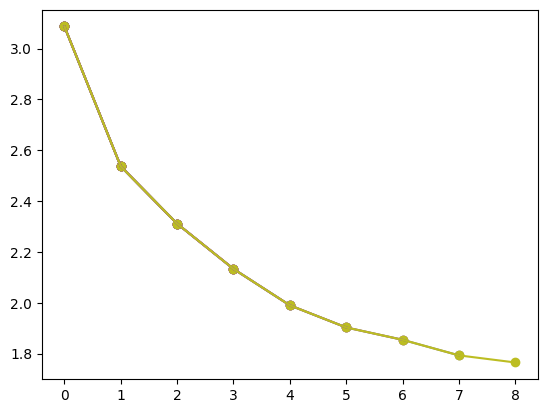

In [ ]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

loss_list = []
model.to(device)
for epoch in range(30):
  np.random.shuffle(files)
  print('EPOCH {}:'.format(epoch + 1))
  model.train(True)
  running_loss = 0.
  last_loss = 0.
  for i in range(len(files)//BATCH_SIZE):
    (image, text_in), text_out = getitiem(i)
    optimizer.zero_grad()
    outputs = model(image, text_in)
    loss = loss_fn(outputs, text_out)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i%10 == 9:
      print(f"Training loss: {running_loss/10}") #first time loss is small because it is dived by 10 where there is only 1
      loss_list.append(running_loss/10)
      saveloss(loss_list)
      running_loss = 0.
    if i%40 == 0:
      print(f"Example Output: {gen(inp_img, [[2]])}")

In [ ]:
_ = list(map(lambda x: np.exp(-0.1*x)+np.random.normal()*0.001*x, list(range(100))))
saveloss(_)

In [ ]:
outputs.shape

In [ ]:
torch.nn.functional.one_hot(data[1], num_classes=72).size()